I began my program by reading in both the adult and Titanic datasets and fixed some structural errors

In [1]:
library(caret)
library(glmnet)
adult = read.csv('adult.csv', header = FALSE)
names(adult)[1]='age'
names(adult)[2]='workclass'
names(adult)[3]='fnlwgt'
names(adult)[4]='education'
names(adult)[5]='education_num'
names(adult)[6]='marital_status'
names(adult)[7]='occupation'
names(adult)[8]='relationship'
names(adult)[9]='race'
names(adult)[10]='sex'
names(adult)[11]='capital_gain'
names(adult)[12]='capital_loss'
names(adult)[13]='hours_per_week'
names(adult)[14]='native_country'
names(adult)[15]='target'

titanic=read.csv("train.csv")

titanic$Survived=factor(titanic$Survived)
titanic$Pclass=factor(titanic$Pclass)
titanic$PassengerId=factor(titanic$PassengerId)
titanic[titanic$Embarked=="",]$Embarked=NA
titanic[titanic$Cabin=="",]$Cabin=NA
titanic$Name=NULL
titanic$PassengerId=NULL
titanic$Ticket=NULL
titanic$Cabin=NULL

Loading required package: lattice
Loading required package: ggplot2
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



Preprocess the data so that it is ready to train predictive models.

In [2]:
miss_handled=function(x){
  for (i in 1:ncol(x)){
    if (is.numeric(x[,i])){
      x[,i][is.na(x[,i])]=mean(x[,i], na.rm=TRUE)
    }else{
      levels=unique(x[,i])
      x[,i][is.na(x[,i])]=levels[which.max(tabulate(match(x[,i], levels)))]
    }
  }
  return(x)
}
adult2=miss_handled(adult)

adult2$native_country=as.character(adult2$native_country)
adult2$education=as.character(adult2$education)
adult2$occupation=as.character(adult2$occupation)

adult2$native_country[adult2$native_country==" United-States"|adult2$native_country==" Canada"|adult2$native_country==" Mexico"]="North America"

adult2$native_country[adult2$native_country==" England"|adult2$native_country==" Germany"|adult2$native_country==" Italy"|adult2$native_country==" Poland"|adult2$native_country==" Portugal"|adult2$native_country==" France"|adult2$native_country==" Scotland"|adult2$native_country==" Greece"|adult2$native_country==" Ireland"|adult2$native_country==" Holand-Netherlands"|adult2$native_country==" Yugoslavia"|adult2$native_country==" Hungary"]="Europe"

adult2$native_country[adult2$native_country==" India"|adult2$native_country==" Cambodia"|adult2$native_country==" Thailand"|adult2$native_country==" Laos"|adult2$native_country==" Taiwan"|adult2$native_country==" China"|adult2$native_country==" Japan"|adult2$native_country==" Vietnam"|adult2$native_country==" Hong"|adult2$native_country==" Philippines"|adult2$native_country==" Iran"]="Asia"

adult2$native_country[adult2$native_country==" Columbia"|adult2$native_country==" Ecuador"]="South America"

adult2$native_country[adult2$native_country==" Cuba"|adult2$native_country==" Jamaica"|adult2$native_country==" South"|adult2$native_country==" Puerto-Rico"|adult2$native_country==" Honduras"|adult2$native_country==" Haiti"|adult2$native_country==" Dominican-Republic"|adult2$native_country==" El-Salvador"|adult2$native_country==" Guatemala"|adult2$native_country==" Peru"|adult2$native_country==" Outlying-US(Guam-USVI-etc)"|adult2$native_country==" Trinadad&Tobago"|adult2$native_country==" Nicaragua"]="Other"

adult2$education[adult2$education==" HS-grad"|adult2$education==" 12th"|adult2$education==" 11th"|adult2$education==" 10th"|adult2$education==" 9th"]="High School"

adult2$education[adult2$education==" Some-college"|adult2$education==" Assoc-acdm"|adult2$education==" Assoc-voc"]="Some College"

adult2$education[adult2$education==" 5th-6th"|adult2$education==" 7th-8th"]="Middle School"

adult2$education[adult2$education==" Preschool"|adult2$education==" 1st-4th"]="Elementary School"

adult2$education[adult2$education==" Bachelors"|adult2$education==" Masters"|adult2$education==" Doctorate"|adult2$education==" Prof-school"]="College Grad"

adult2$occupation[adult2$occupation==" Transport-moving"|adult2$occupation==" Farming-fishing"|adult2$occupation==" Machine-op-inspct"]="Physical Labor"
adult2$occupation[adult2$occupation==" Handlers-cleaners"|adult2$occupation==" Priv-house-serv"|adult2$occupation==" Tech-support"]="Services"
adult2$occupation[adult2$occupation==" Exec-managerial"|adult2$occupation==" Sales"|adult2$occupation==" Adm-clerical"]="Corporate"
adult2$occupation[adult2$occupation==" Armed-Forces"|adult2$occupation==" Protective-serv"]="Defense"
adult2$occupation[adult2$occupation==" Other-service"|adult2$occupation==" Prof-specialty"|adult2$occupation==" Craft-repair"]="Other"

adult2$native_country=as.factor(adult2$native_country)
adult2$education=as.factor(adult2$education)
adult2$occupation=as.factor(adult2$occupation)

adult2$workclass=is.numeric(adult2$workclass)
adult2$education=is.numeric(adult2$education)
adult2$marital_status=is.numeric(adult2$marital_status)
adult2$occupation=is.numeric(adult2$occupation)
adult2$relationship=is.numeric(adult2$relationship)
adult2$race=is.numeric(adult2$race)
adult2$sex=is.numeric(adult2$sex)
adult2$native_country=is.numeric(adult2$native_country)

titanic2=miss_handled(titanic)

set.seed(2018)
splitIndex1=createDataPartition(adult2$target, p=.70, list=FALSE, times=1)
train_adult=adult2[splitIndex1,]
test_adult=adult2[-splitIndex1,]

splitIndex2=createDataPartition(titanic2$Survived, p=.70, list=FALSE, times=1)
train_titanic=titanic2[splitIndex2,]
test_titanic=titanic2[-splitIndex2,]

Train a random forest with 7-fold cross validation.  Report the accuracy of the forest.

In [3]:
myGrid=expand.grid(mtry=2,splitrule="gini",min.node.size=c(1:3))
myTrain=trainControl(method ="cv", number = 7, verboseIter = TRUE)

forest7a=train(target~., data=train_adult, method="ranger",trControl=myTrain,tuneGrid=myGrid)
max(forest7a$results["Accuracy"])

forest7t=train(Survived~.,data=train_titanic, method="ranger", trControl=myTrain, tuneGrid=myGrid)
max(forest7t$results["Accuracy"])

+ Fold1: mtry=2, splitrule=gini, min.node.size=1 
- Fold1: mtry=2, splitrule=gini, min.node.size=1 
+ Fold1: mtry=2, splitrule=gini, min.node.size=2 
- Fold1: mtry=2, splitrule=gini, min.node.size=2 
+ Fold1: mtry=2, splitrule=gini, min.node.size=3 
- Fold1: mtry=2, splitrule=gini, min.node.size=3 
+ Fold2: mtry=2, splitrule=gini, min.node.size=1 
- Fold2: mtry=2, splitrule=gini, min.node.size=1 
+ Fold2: mtry=2, splitrule=gini, min.node.size=2 
- Fold2: mtry=2, splitrule=gini, min.node.size=2 
+ Fold2: mtry=2, splitrule=gini, min.node.size=3 
- Fold2: mtry=2, splitrule=gini, min.node.size=3 
+ Fold3: mtry=2, splitrule=gini, min.node.size=1 
- Fold3: mtry=2, splitrule=gini, min.node.size=1 
+ Fold3: mtry=2, splitrule=gini, min.node.size=2 
- Fold3: mtry=2, splitrule=gini, min.node.size=2 
+ Fold3: mtry=2, splitrule=gini, min.node.size=3 
- Fold3: mtry=2, splitrule=gini, min.node.size=3 
+ Fold4: mtry=2, splitrule=gini, min.node.size=1 
- Fold4: mtry=2, splitrule=gini, min.node.size=1 


[1] 0.7591805

+ Fold1: mtry=2, splitrule=gini, min.node.size=1 
- Fold1: mtry=2, splitrule=gini, min.node.size=1 
+ Fold1: mtry=2, splitrule=gini, min.node.size=2 
- Fold1: mtry=2, splitrule=gini, min.node.size=2 
+ Fold1: mtry=2, splitrule=gini, min.node.size=3 
- Fold1: mtry=2, splitrule=gini, min.node.size=3 
+ Fold2: mtry=2, splitrule=gini, min.node.size=1 
- Fold2: mtry=2, splitrule=gini, min.node.size=1 
+ Fold2: mtry=2, splitrule=gini, min.node.size=2 
- Fold2: mtry=2, splitrule=gini, min.node.size=2 
+ Fold2: mtry=2, splitrule=gini, min.node.size=3 
- Fold2: mtry=2, splitrule=gini, min.node.size=3 
+ Fold3: mtry=2, splitrule=gini, min.node.size=1 
- Fold3: mtry=2, splitrule=gini, min.node.size=1 
+ Fold3: mtry=2, splitrule=gini, min.node.size=2 
- Fold3: mtry=2, splitrule=gini, min.node.size=2 
+ Fold3: mtry=2, splitrule=gini, min.node.size=3 
- Fold3: mtry=2, splitrule=gini, min.node.size=3 
+ Fold4: mtry=2, splitrule=gini, min.node.size=1 
- Fold4: mtry=2, splitrule=gini, min.node.size=1 


[1] 0.8319957

Train a decision tree with 10-fold cross validation.  Report the accuracy. 

In [4]:
myTrain2=trainControl(method ="cv", number = 10, verboseIter = TRUE)

tree10a=train(target~., data=train_adult, method="rpart",trControl=myTrain2)
max(tree10a$results["Accuracy"])

tree10t=train(Survived~., data=train_titanic, method="rpart",trControl=myTrain2)
max(tree10t$results["Accuracy"])

+ Fold01: cp=0.007925 
- Fold01: cp=0.007925 
+ Fold02: cp=0.007925 
- Fold02: cp=0.007925 
+ Fold03: cp=0.007925 
- Fold03: cp=0.007925 
+ Fold04: cp=0.007925 
- Fold04: cp=0.007925 
+ Fold05: cp=0.007925 
- Fold05: cp=0.007925 
+ Fold06: cp=0.007925 
- Fold06: cp=0.007925 
+ Fold07: cp=0.007925 
- Fold07: cp=0.007925 
+ Fold08: cp=0.007925 
- Fold08: cp=0.007925 
+ Fold09: cp=0.007925 
- Fold09: cp=0.007925 
+ Fold10: cp=0.007925 
- Fold10: cp=0.007925 
Aggregating results
Selecting tuning parameters
Fitting cp = 0.00792 on full training set


[1] 0.8260433

+ Fold01: cp=0.02917 
- Fold01: cp=0.02917 
+ Fold02: cp=0.02917 
- Fold02: cp=0.02917 
+ Fold03: cp=0.02917 
- Fold03: cp=0.02917 
+ Fold04: cp=0.02917 
- Fold04: cp=0.02917 
+ Fold05: cp=0.02917 
- Fold05: cp=0.02917 
+ Fold06: cp=0.02917 
- Fold06: cp=0.02917 
+ Fold07: cp=0.02917 
- Fold07: cp=0.02917 
+ Fold08: cp=0.02917 
- Fold08: cp=0.02917 
+ Fold09: cp=0.02917 
- Fold09: cp=0.02917 
+ Fold10: cp=0.02917 
- Fold10: cp=0.02917 
Aggregating results
Selecting tuning parameters
Fitting cp = 0.0292 on full training set


[1] 0.8032258

What are the selection of the hyperparameters (mtry, splitrule, min.mode.size) in the random forest in 2? 

In [5]:
forest7a
forest7t

Random Forest 

22793 samples
   14 predictor
    2 classes: ' <=50K', ' >50K' 

No pre-processing
Resampling: Cross-Validated (7 fold) 
Summary of sample sizes: 19537, 19537, 19537, 19537, 19537, 19536, ... 
Resampling results across tuning parameters:

  min.node.size  Accuracy   Kappa
  1              0.7591805  0    
  2              0.7591805  0    
  3              0.7591805  0    

Tuning parameter 'mtry' was held constant at a value of 2
Tuning
 parameter 'splitrule' was held constant at a value of gini
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 2, splitrule = gini
 and min.node.size = 1.

Random Forest 

625 samples
  7 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (7 fold) 
Summary of sample sizes: 536, 535, 535, 536, 536, 536, ... 
Resampling results across tuning parameters:

  min.node.size  Accuracy   Kappa    
  1              0.8207954  0.6035934
  2              0.8208133  0.6037122
  3              0.8319957  0.6273577

Tuning parameter 'mtry' was held constant at a value of 2
Tuning
 parameter 'splitrule' was held constant at a value of gini
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 2, splitrule = gini
 and min.node.size = 3.

Print out the plot of the random forest.

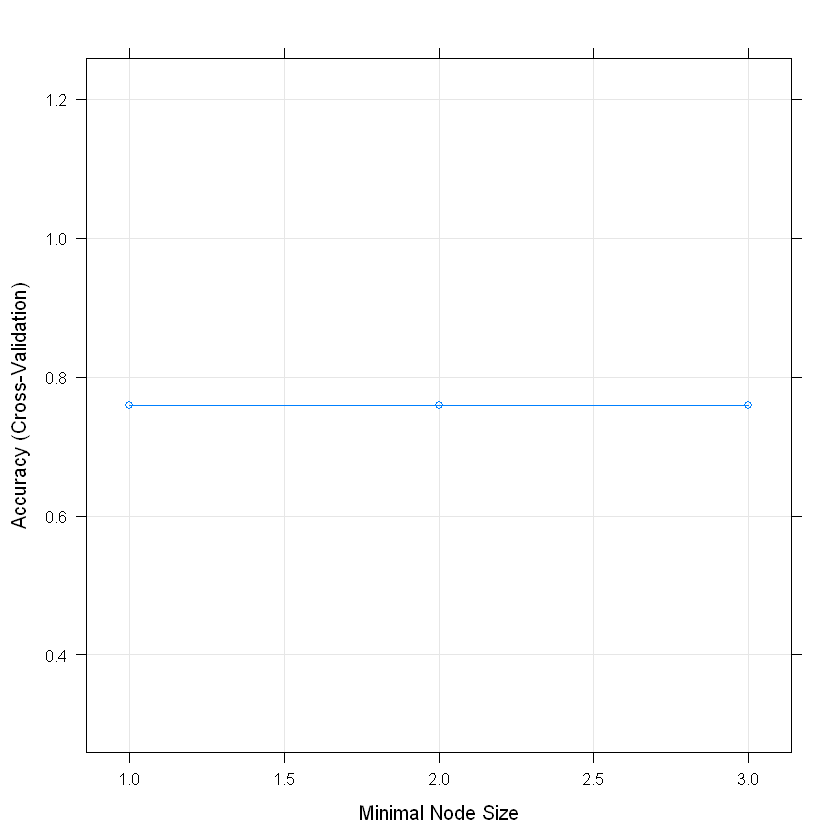

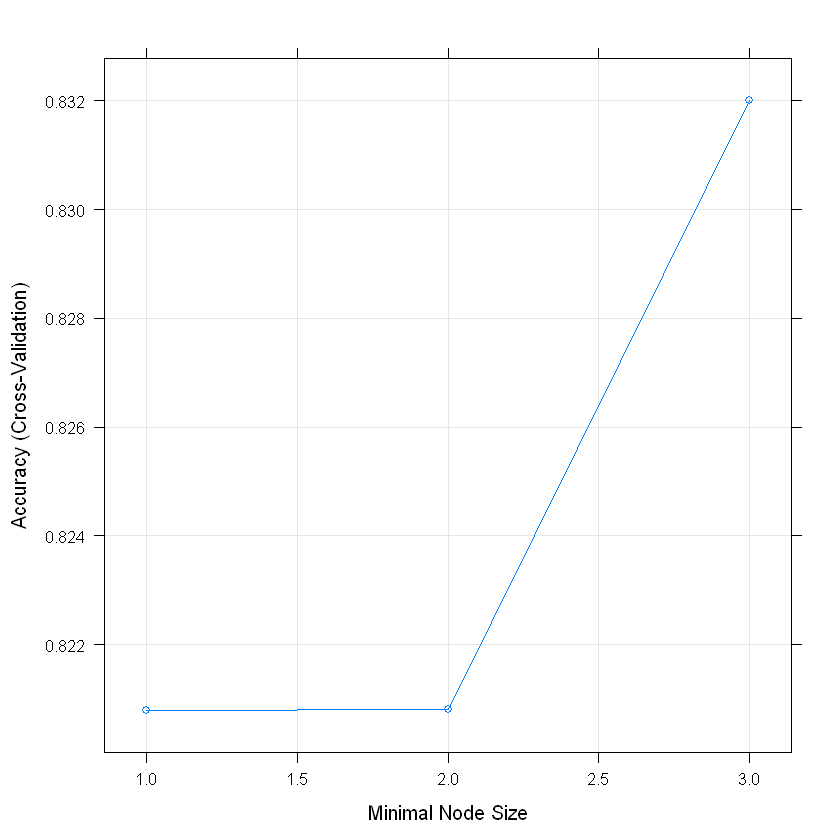

In [6]:
plot(forest7a)
plot(forest7t)

Tune the three hyperparameters of the random forest with mtry running 3 possible values, splitrule running all its possible values (gini and extratrees) and min.node.size running from 1 to 4

In [7]:
myGrid2=expand.grid(mtry=c(1:3),splitrule=c("gini","extratrees"),min.node.size=c(1:4))
myTrain3=trainControl(method ="cv", number = 7, verboseIter = TRUE)

forest_a=train(target~., data=train_adult, method="ranger",trControl=myTrain3, tuneGrid=myGrid2)
forest_a

forest_t=train(Survived~., data=train_titanic, method="ranger",trControl=myTrain3, tuneGrid=myGrid2)
forest_t

+ Fold1: mtry=1, splitrule=gini, min.node.size=1 
- Fold1: mtry=1, splitrule=gini, min.node.size=1 
+ Fold1: mtry=2, splitrule=gini, min.node.size=1 
- Fold1: mtry=2, splitrule=gini, min.node.size=1 
+ Fold1: mtry=3, splitrule=gini, min.node.size=1 
- Fold1: mtry=3, splitrule=gini, min.node.size=1 
+ Fold1: mtry=1, splitrule=extratrees, min.node.size=1 
- Fold1: mtry=1, splitrule=extratrees, min.node.size=1 
+ Fold1: mtry=2, splitrule=extratrees, min.node.size=1 
- Fold1: mtry=2, splitrule=extratrees, min.node.size=1 
+ Fold1: mtry=3, splitrule=extratrees, min.node.size=1 
- Fold1: mtry=3, splitrule=extratrees, min.node.size=1 
+ Fold1: mtry=1, splitrule=gini, min.node.size=2 
- Fold1: mtry=1, splitrule=gini, min.node.size=2 
+ Fold1: mtry=2, splitrule=gini, min.node.size=2 
- Fold1: mtry=2, splitrule=gini, min.node.size=2 
+ Fold1: mtry=3, splitrule=gini, min.node.size=2 
- Fold1: mtry=3, splitrule=gini, min.node.size=2 
+ Fold1: mtry=1, splitrule=extratrees, min.node.size=2 
- Fold1:

Random Forest 

22793 samples
   14 predictor
    2 classes: ' <=50K', ' >50K' 

No pre-processing
Resampling: Cross-Validated (7 fold) 
Summary of sample sizes: 19537, 19536, 19537, 19537, 19537, 19537, ... 
Resampling results across tuning parameters:

  mtry  splitrule   min.node.size  Accuracy   Kappa     
  1     gini        1              0.7591805  0.00000000
  1     gini        2              0.7591805  0.00000000
  1     gini        3              0.7591805  0.00000000
  1     gini        4              0.7591805  0.00000000
  1     extratrees  1              0.7591805  0.00000000
  1     extratrees  2              0.7591805  0.00000000
  1     extratrees  3              0.7591805  0.00000000
  1     extratrees  4              0.7591805  0.00000000
  2     gini        1              0.7591805  0.00000000
  2     gini        2              0.7591805  0.00000000
  2     gini        3              0.7591805  0.00000000
  2     gini        4              0.7591805  0.00000000
  2 

+ Fold1: mtry=1, splitrule=gini, min.node.size=1 
- Fold1: mtry=1, splitrule=gini, min.node.size=1 
+ Fold1: mtry=2, splitrule=gini, min.node.size=1 
- Fold1: mtry=2, splitrule=gini, min.node.size=1 
+ Fold1: mtry=3, splitrule=gini, min.node.size=1 
- Fold1: mtry=3, splitrule=gini, min.node.size=1 
+ Fold1: mtry=1, splitrule=extratrees, min.node.size=1 
- Fold1: mtry=1, splitrule=extratrees, min.node.size=1 
+ Fold1: mtry=2, splitrule=extratrees, min.node.size=1 
- Fold1: mtry=2, splitrule=extratrees, min.node.size=1 
+ Fold1: mtry=3, splitrule=extratrees, min.node.size=1 
- Fold1: mtry=3, splitrule=extratrees, min.node.size=1 
+ Fold1: mtry=1, splitrule=gini, min.node.size=2 
- Fold1: mtry=1, splitrule=gini, min.node.size=2 
+ Fold1: mtry=2, splitrule=gini, min.node.size=2 
- Fold1: mtry=2, splitrule=gini, min.node.size=2 
+ Fold1: mtry=3, splitrule=gini, min.node.size=2 
- Fold1: mtry=3, splitrule=gini, min.node.size=2 
+ Fold1: mtry=1, splitrule=extratrees, min.node.size=2 
- Fold1:

Random Forest 

625 samples
  7 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (7 fold) 
Summary of sample sizes: 536, 535, 536, 536, 536, 536, ... 
Resampling results across tuning parameters:

  mtry  splitrule   min.node.size  Accuracy   Kappa    
  1     gini        1              0.8000178  0.5418144
  1     gini        2              0.8016230  0.5457717
  1     gini        3              0.8031924  0.5488980
  1     gini        4              0.8031746  0.5498558
  1     extratrees  1              0.8112538  0.5695576
  1     extratrees  2              0.8096308  0.5664719
  1     extratrees  3              0.8064384  0.5574435
  1     extratrees  4              0.8096308  0.5662020
  2     gini        1              0.8304441  0.6255072
  2     gini        2              0.8304619  0.6243181
  2     gini        3              0.8352773  0.6360532
  2     gini        4              0.8288746  0.6217482
  2     extratrees  1              0.8288746

Print out the tuning plot of the random forest.

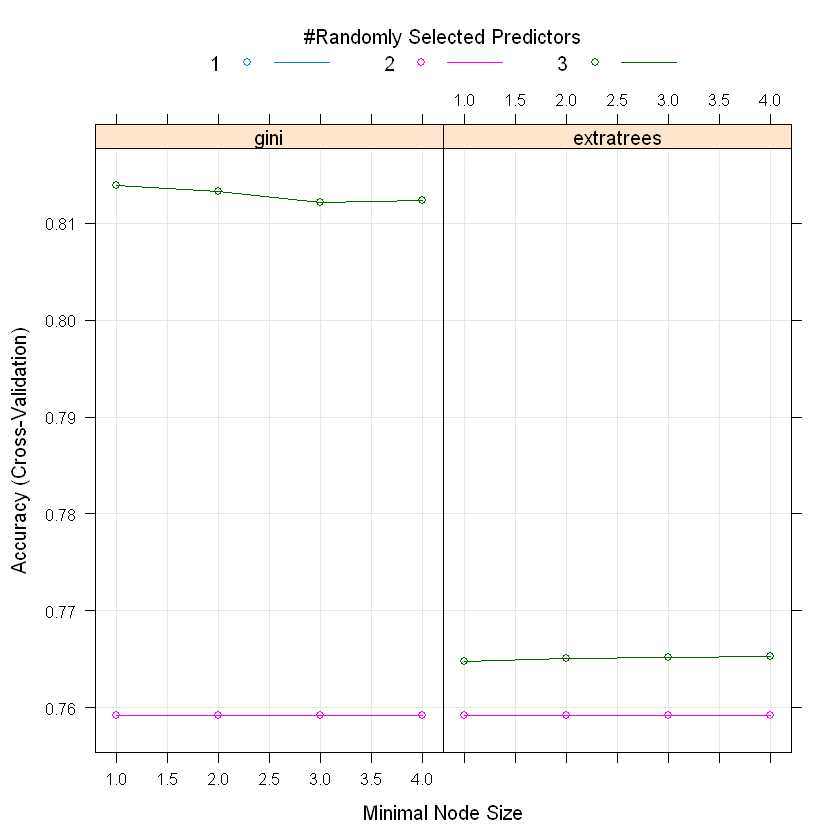

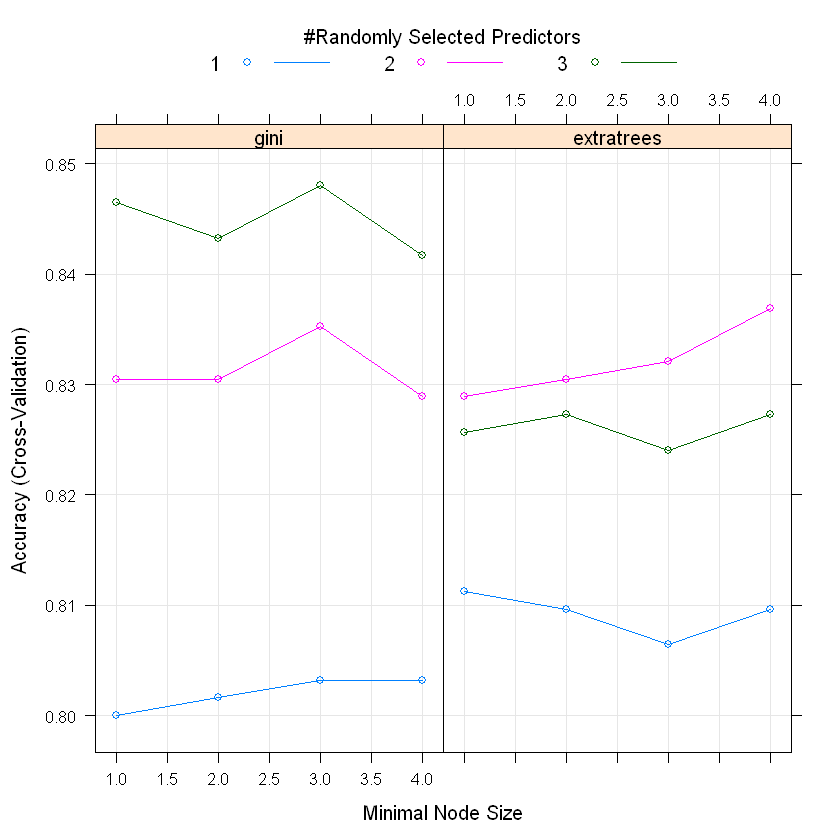

In [8]:
plot(forest_a)
plot(forest_t)

Compare the performances of the default glmnet model and a tuned glmnet model.

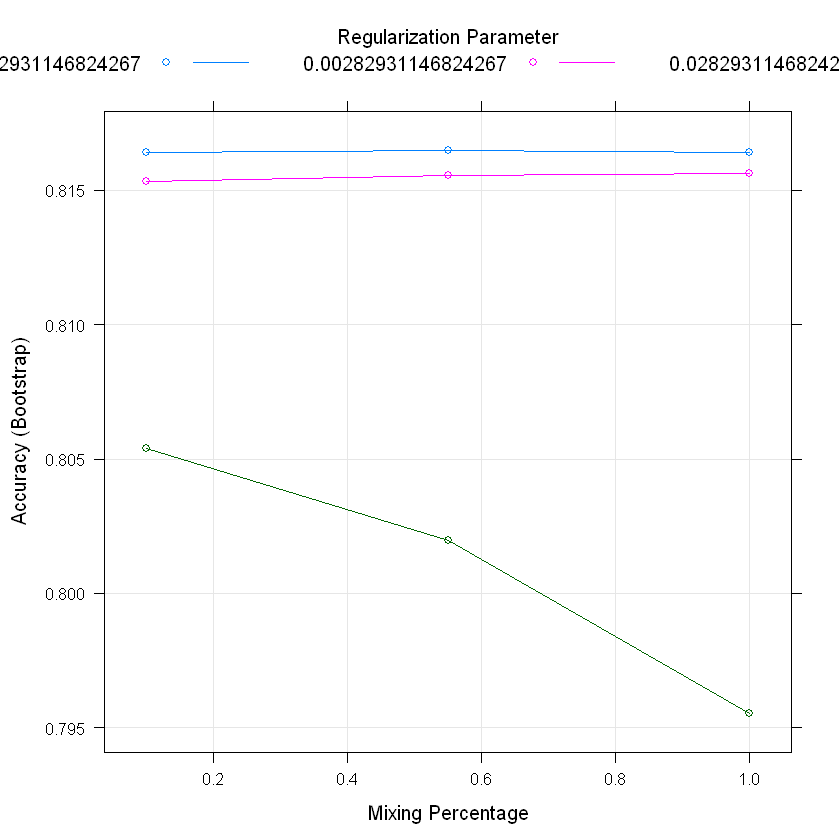

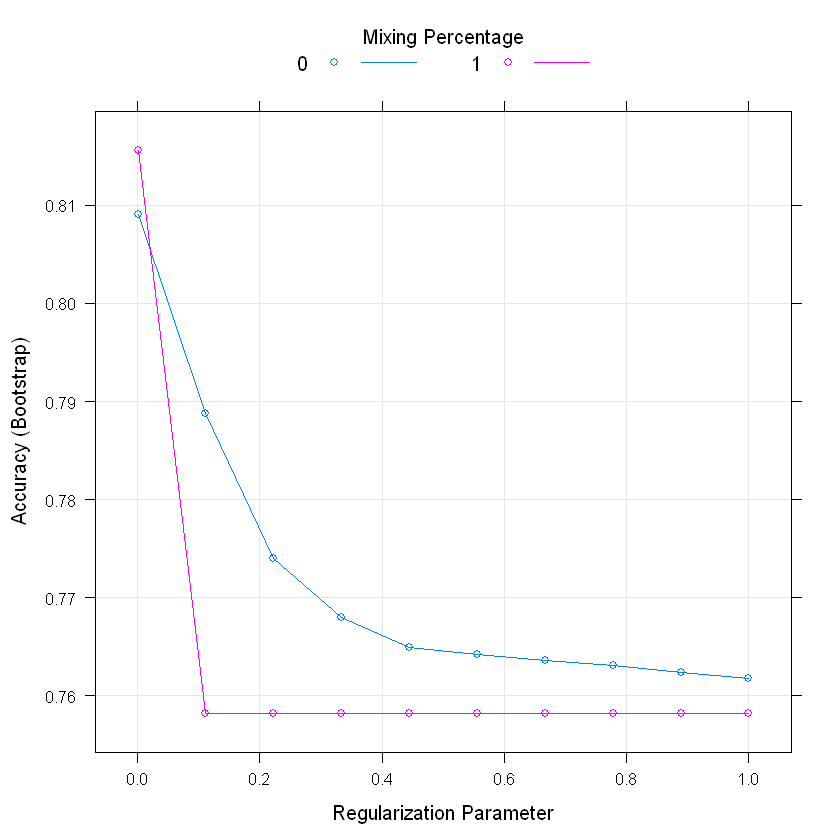

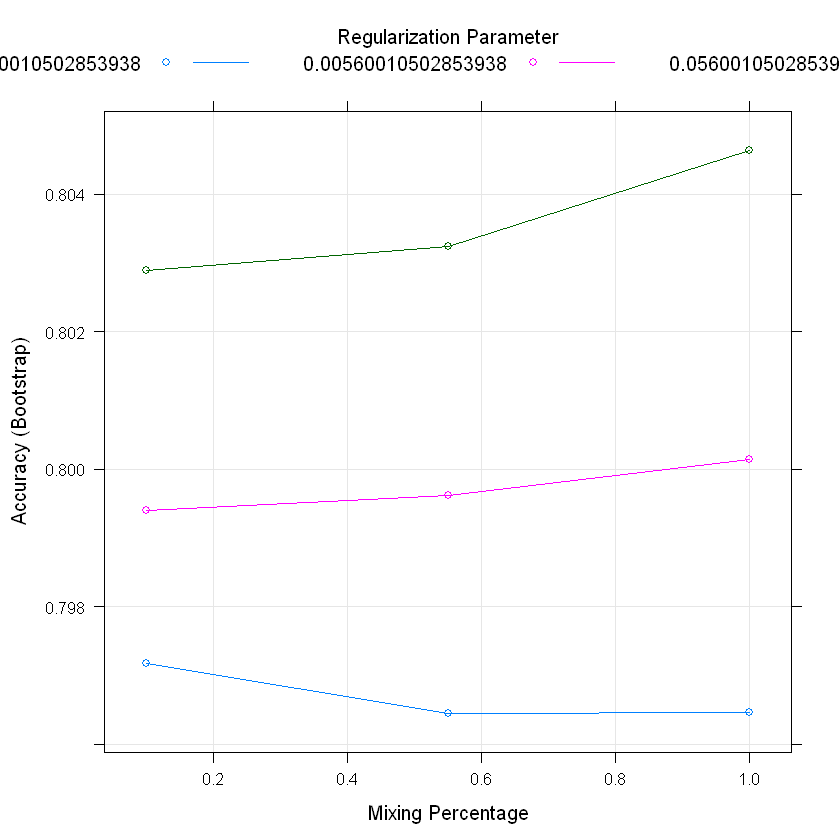

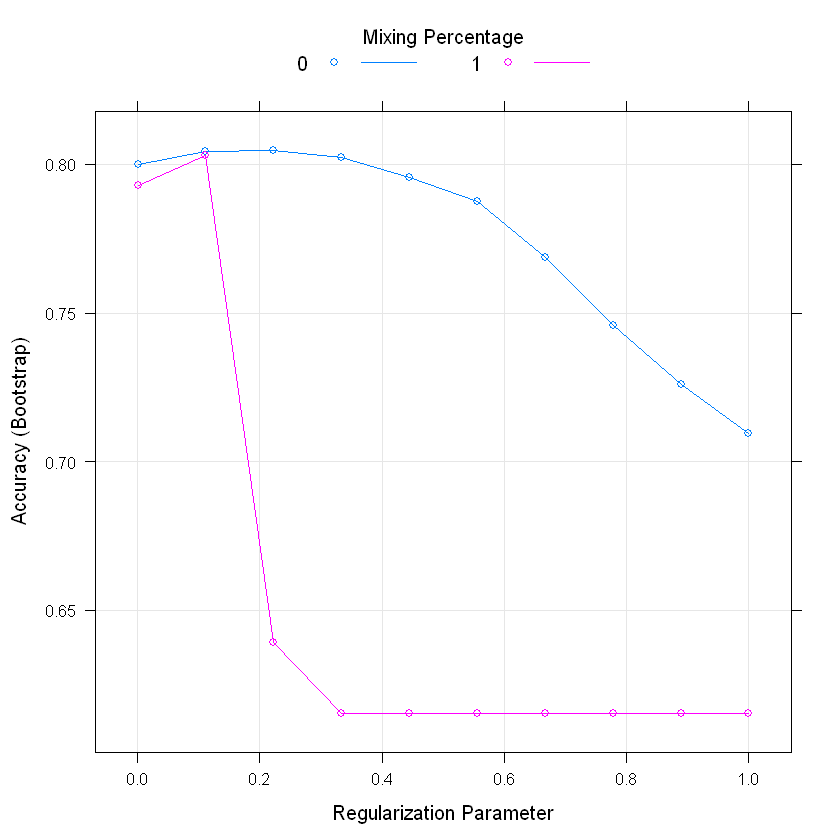

In [9]:
myGrid3=expand.grid(.alpha=0:1,.lambda=seq(0.001,1,length=10))

model_glm_a=train(target~., data=train_adult, method="glmnet")
model_glm2_a=train(target~., data=train_adult, method="glmnet", tuneGrid=myGrid3)
plot(model_glm_a)
plot(model_glm2_a)

model_glm_t=train(Survived~., data=train_titanic, method="glmnet")
model_glm2_t=train(Survived~., data=train_titanic, method="glmnet", tuneGrid=myGrid3)
plot(model_glm_t)
plot(model_glm2_t)